In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
folder = 'data'
df = pd.read_excel(os.path.join(folder, '20211128 - Full DART Data (Model & Test).xlsx'), header=2)
df.head()

,Sample,Class,Sample Types,SRN,59.00498,72.00792,74.00967,75.00427,77.00585,77.00646,...,534.22864,545.23129,548.2292,564.22822,578.23102,589.23387,592.23132,608.23108,622.23371,636.23384
0,1,c1,Model,SRN00001_DART_NHM_1,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2,c1,Model,SRN00001_DART_NHM_2,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,3,c1,Model,SRN00001_DART_NHM_3,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4,c2,Model,SRN00002_DART_NHM_1,0.0,0.0,0.0,0.00,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,5,c2,Model,SRN00002_DART_NHM_2,0.0,0.0,0.0,5.83,0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
labeled_df = df[df['Sample Types'] == 'Model']
recol = [(float('.'.join(col.split('.')[:2])) if isinstance(col, str) else col) for col in df.columns[4:]]
unique_classes = labeled_df['Class'].unique()

In [5]:
labeled_df['Class'].value_counts()

c3     52
c10    48
c4     36
c5     36
c1     35
c6     28
c9     21
c7     20
c11    17
c12    15
c2     12
c8      6
c13     6
c14     4
Name: Class, dtype: int64

In [6]:
def plot(df, unique_classes):
    for label in unique_classes:
        df = labeled_df[labeled_df['Class'] == label]

        for ind, row in df.iterrows():
            plt.plot(recol, row.iloc[4:])
            plt.title(row["Sample"])
            plt.savefig(os.path.join("figures_real_data", f"sample_class_{label}_sample_{row['Sample']}.png"))
            plt.close()
    return

# plot(df, unique_classes)

In [7]:
savefolder = 'figures_real_data'

def extractor(labeled_df, unique_classes, recol, gt=25):

    #for label in unique_classes:
    label = unique_classes[0]
    df = labeled_df[labeled_df['Class'] == label]
    data = df[df.columns[4:]].values

    data[data<gt] = 0
    active_peaks_locs = (data > gt).any(axis=0)
    active_peaks = data[:, active_peaks_locs]
    active_recol = [r for r,b in zip(recol, active_peaks_locs) if b]
    for i in range(active_peaks.shape[1]):
        plt.plot(active_peaks[:,i])
        plt.title(f'{label} - {active_recol[i]}')
        plt.savefig(os.path.join(savefolder, f'peak_activation_class_{label}_peak_{i}.png'))
        plt.close()

extractor(labeled_df, unique_classes, recol)

(336, 1125) (336, 1125)


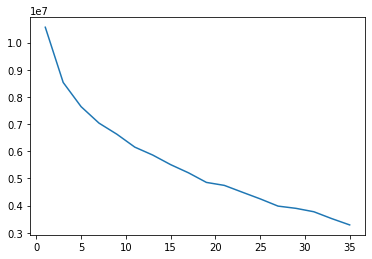

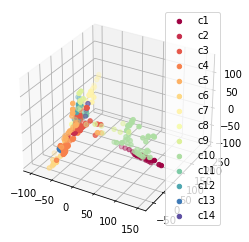

              precision    recall  f1-score   support

          c1       0.73      1.00      0.85        11
         c10       1.00      0.71      0.83        14
         c11       1.00      0.80      0.89         5
         c12       1.00      0.75      0.86         4
         c13       1.00      1.00      1.00         2
         c14       0.33      1.00      0.50         1
          c2       0.50      1.00      0.67         4
          c3       1.00      0.56      0.72        16
          c4       1.00      0.82      0.90        11
          c5       1.00      0.82      0.90        11
          c6       0.50      0.75      0.60         8
          c7       0.75      1.00      0.86         6
          c8       1.00      1.00      1.00         2
          c9       0.86      1.00      0.92         6

    accuracy                           0.81       101
   macro avg       0.83      0.87      0.82       101
weighted avg       0.88      0.81      0.82       101

[[11  0  0  0  0  0  0  0

In [10]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import matplotlib
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

gt=25

big_df = labeled_df.copy()
df = big_df[big_df['Class'].isin(unique_classes)]  # [:10]
print(df.shape, labeled_df.shape)
data = df[df.columns[4:]].values

data[data<gt] = 0
active_peaks_locs = (data > gt).any(axis=0)
active_peaks = data[:, active_peaks_locs]

inertias = []
ks = range(1,36,2)
for k in ks:
    km = KMeans(n_clusters=k)
    km.fit(active_peaks)
    inertias.append(km.inertia_)

plt.plot(ks, inertias)
plt.show()

#colors = ['red', 'green', 'blue', 'orange', 'brown']
df_unique_classes = df['Class'].unique()
cmap = matplotlib.cm.get_cmap('Spectral')
colors = [cmap(i) for i in np.linspace(0,1,len(df_unique_classes))]

df['class_color'] = df['Class']
df['class_color'] = df['class_color'].map(dict(zip(df_unique_classes, colors[:len(df_unique_classes)])))

fig = plt.figure()
ax = fig.add_subplot(projection='3d')

pca = PCA(n_components=3)
pca_X = pca.fit_transform(active_peaks)
for label in df_unique_classes:
    mask = df['Class'] == label
    sub = df.loc[mask]
    ax.scatter(pca_X[mask,0], pca_X[mask,1], pca_X[mask,2], c=sub['class_color'], label=label)
plt.legend()
plt.show()

train_df, test_df, Xtrain, Xtest = train_test_split(df, active_peaks, train_size=0.7, stratify=df['Class'])

ytrain = train_df['Class'].values
ytest = test_df['Class'].values

lda = LinearDiscriminantAnalysis()
lda.fit(Xtrain, ytrain)
ypred = lda.predict(Xtest)

print(classification_report(ytest, ypred))
print(confusion_matrix(ytest, ypred))